<a href="https://colab.research.google.com/github/dtabuena/Images/blob/main/Cell_Pose.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
!pip install python-bioformats


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [50]:
import numpy as np
import javabridge
import bioformats
import skimage
from skimage import filters
from matplotlib import pyplot as plt
import matplotlib
import os
import scipy
from scipy import ndimage as ndi
javabridge.start_vm(class_path=bioformats.JARS)



def get_drobox_folder(link, new_filename):
    'Download a folder from dropbox and unzip'
    zipped_file_path = "/content/"+new_filename + ".zip"
    unzipped_file_path = "/content/"+new_filename
    if not( os.path.exists(zipped_file_path)):
        !wget -O $zipped_file_path $link    # download with new name
    !echo A | unzip $zipped_file_path -d $unzipped_file_path 
    return new_filename

def get_sub_files(rootdir):
    'Recursively search subfolders and return a list of all files'
    file_list =[]
    for rootdir, dirs, files in os.walk(rootdir): 
            file_list.extend([os.path.join(rootdir,f) for f in files])
    return file_list

folder = get_drobox_folder('https://www.dropbox.com/sh/rv7944fsk9p1mvk/AAC0E8ZTPkr-pfgK8zdC730Sa?dl=0', 'images')
file_list = get_sub_files(folder)
file_list.sort()

Archive:  /content/images.zip
mapname:  conversion of  failed
replace /content/images/MDGA2_08-24-22_DG_40X_2XZoom_1.oir? [y]es, [n]o, [A]ll, [N]one, [r]ename:  extracting: /content/images/MDGA2_08-24-22_DG_40X_2XZoom_1.oir  
 extracting: /content/images/MDGA2_08-25-22_DG_40X_2XZoom_1.oir  
 extracting: /content/images/Nell2_08-04-22_DG_40X_2XZoom_1.oir  
 extracting: /content/images/Nell2_08-04-22_CA3_40X_2XZoom_1.oir  
 extracting: /content/images/RNF182_08-15-22_CA3_40X_2XZoom_1.oir  
 extracting: /content/images/MDGA2_08-22-22_S001_DG_40X_2XZoom_1.oir  
 extracting: /content/images/Nell2_08-10-22__S001_DG_40X_2XZoom_2.oir  
 extracting: /content/images/RNF182_08-17-22_S001_DG_40X_2XZoom_1.oir  
 extracting: /content/images/Nell2_08-10-22__S001_CA3_40X_2XZoom_2.oir  
 extracting: /content/images/RNF182_08-12-22_S001_CA3_40X_2XZoom_1.oir  
 extracting: /content/images/Other/DifferentExposure_RNF182_08-15-22_DG_40X_2XZoom_1.oir  
 extracting: /content/images/Other/BrighterSettings_Nel

In [51]:
my_reader = bioformats.get_image_reader('my_image', file_list[1])

c_dim = my_reader.rdr.getSizeC()
z_dim = my_reader.rdr.getSizeZ()
x_dim = my_reader.rdr.getSizeX()
y_dim = my_reader.rdr.getSizeY()
print(x_dim,y_dim,c_dim,z_dim)

image = np.empty([x_dim,y_dim,c_dim,z_dim])
for zi in range(z_dim):
    img_zi = my_reader.read(c=None, z=zi,rescale=True)
    image[:,:,:,zi] = img_zi


image_zproj = np.max(image,axis=3)
# image = np.expand_dims(image_zproj, axis=-1)
print(image.shape)
for ci in range(image.shape[2]):
    cim = image[:,:,ci,:]
    flat = cim.flatten()
    max= np.percentile(flat,100)
    assert max>0 , print(flat)
    cim = cim/max
    image[:,:,ci,:] = cim

800 800 3 16
(800, 800, 3, 16)


In [52]:
import os
os.environ["CELLPOSE_LOCAL_MODELS_PATH"] = "/PATH_FOR_MODELS/"

!pip install cellpose
from cellpose import models


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


30


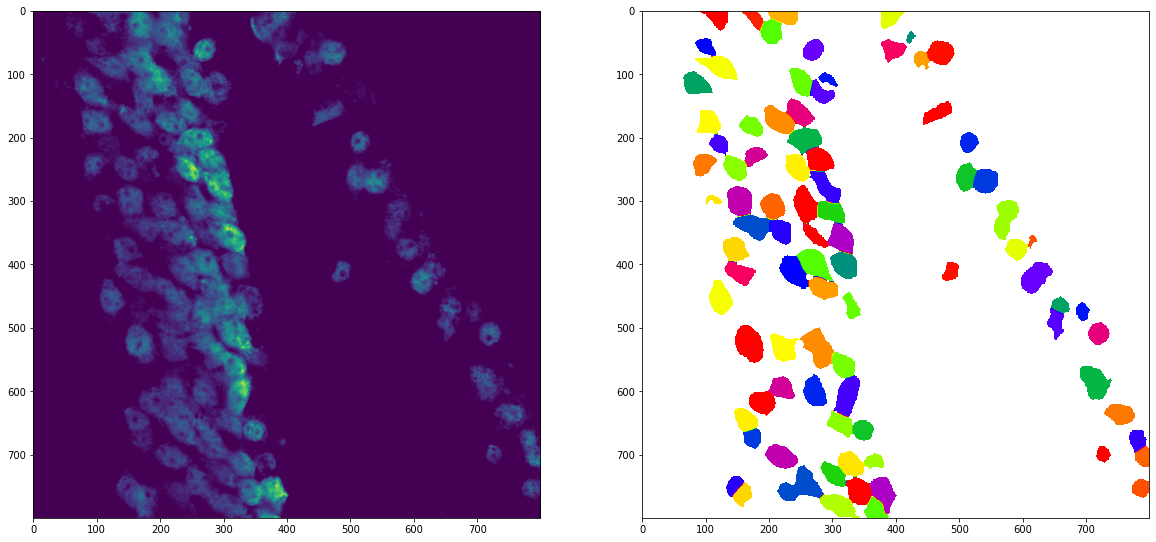

In [53]:
model = models.Cellpose(model_type='cyto')
imgs = [image[:,:,2,zi] for zi in range(image.shape[3])]
# print(imgs)

imgs=imgs[5]
masks, flows, styles, diams = model.eval(imgs, diameter=30, channels=[0,0]) 
masks = masks.astype(float)
masks[masks==0] = np.nan
n=2
psize = 10
fig, axs = plt.subplots(1,n,figsize=(psize*n,psize))
axs= axs.flatten()
axs[0].imshow(imgs)
axs[1].imshow(masks,cmap='prism')
# plt.show()
print(diams)

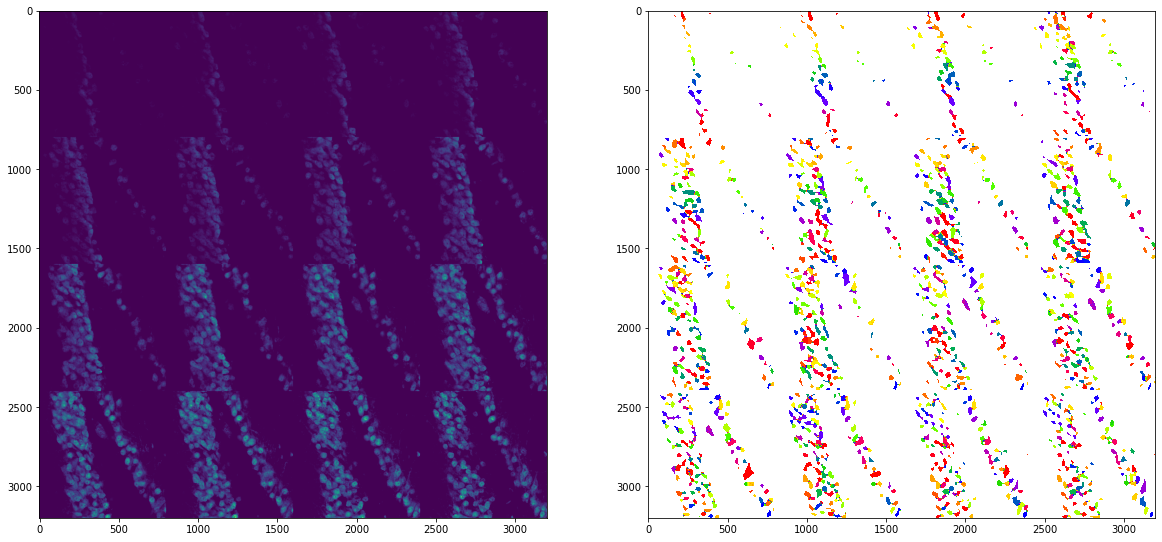

In [54]:
import skimage


model = models.Cellpose(model_type='cyto')
# imgs = [image[:,:,2,zi] for zi in range(image.shape[3])]
imgs = image[:,:,2,:]
imgs = np.transpose(imgs,(2,0,1))
# imgs = imgs[0:4,400:600,200:400]
masks_og, flows, styles, diams = model.eval(imgs, diameter=35, channels=[0,0], stitch_threshold=.001,do_3D=False) #anistropy
masks = masks_og.copy()
masks = masks.astype(float)
masks[masks==0] = np.nan
n=2
psize = 10
fig, axs = plt.subplots(1,n,figsize=(psize*n,psize))
axs= axs.flatten()
axs[0].imshow(skimage.util.montage(imgs))
axs[1].imshow(skimage.util.montage(masks),cmap='prism')
# plt.show()

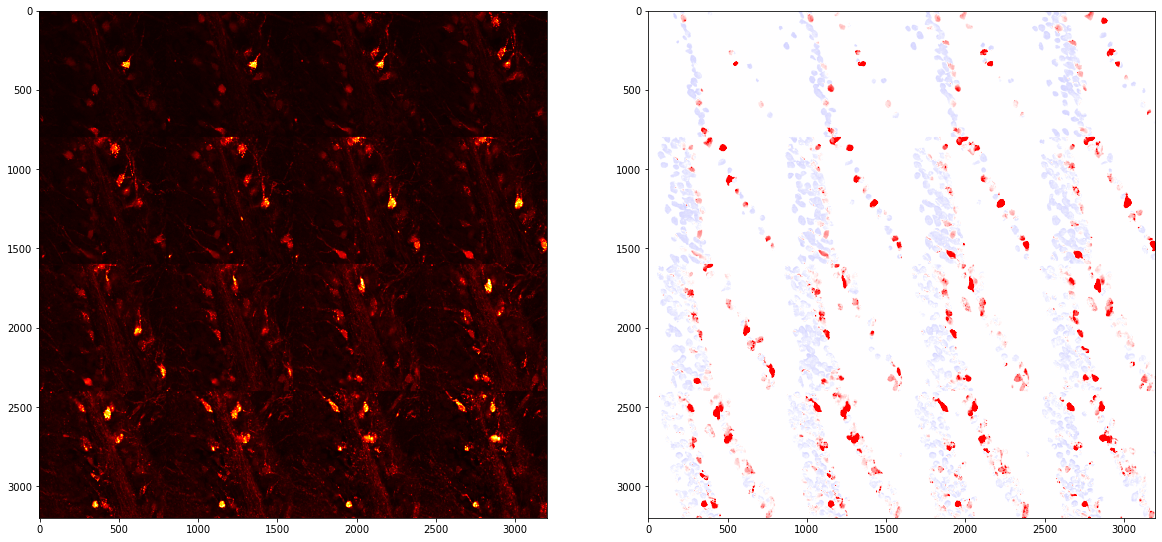

In [103]:
mask_bool = masks>0
red_stack = np.transpose(image[:,:,1,:],(2,0,1))
red_zscore = red_stack.copy()
red_zscore = (red_zscore - np.mean(red_zscore.flatten()))/np.std(red_zscore.flatten())
red_zscore_shift = red_zscore-0
# red_stack_med = red_stack.copy()
# red_stack_med = red_stack_med-.1
red_zscore_shift[np.logical_not(mask_bool)]=0
n=2
psize = 10
fig, axs = plt.subplots(1,n,figsize=(psize*n,psize))
axs= axs.flatten()
axs[0].imshow(skimage.util.montage(red_stack),cmap='hot')
m = np.max(np.abs(red_zscore_shift.flatten()))
m=3
axs[1].imshow(skimage.util.montage(red_zscore_shift),cmap='bwr', vmin=-m,vmax=m)

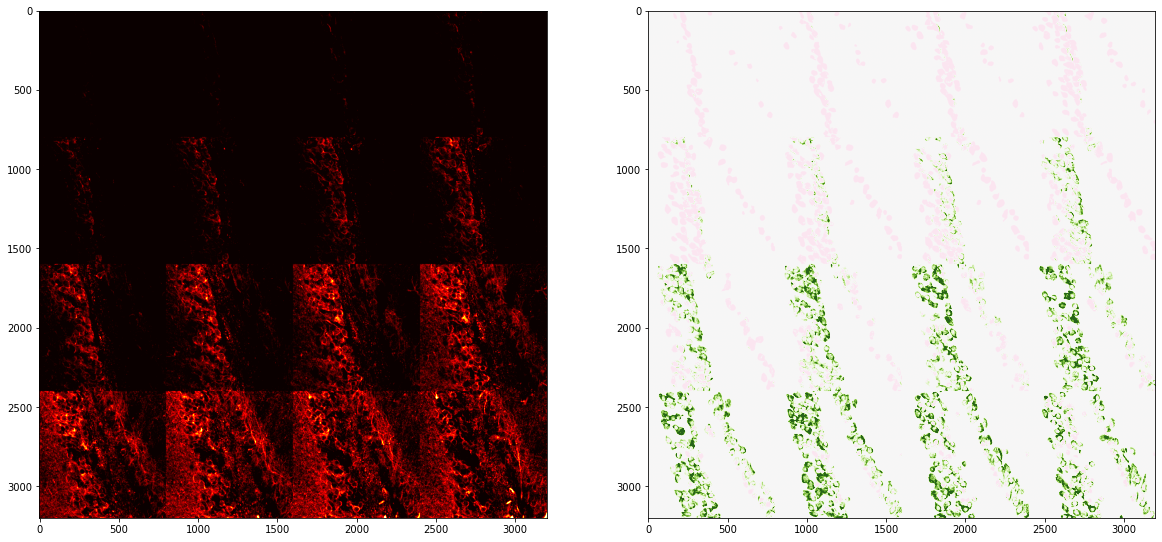

In [104]:
mask_bool = masks>0
green_stack = np.transpose(image[:,:,0,:],(2,0,1))
green_zscore = green_stack.copy()
green_zscore = (green_zscore - np.mean(green_zscore.flatten()))/np.std(green_zscore.flatten())
green_zscore_shift = green_zscore-0
# red_stack_med = red_stack.copy()
# red_stack_med = red_stack_med-.1
green_zscore_shift[np.logical_not(mask_bool)]=0
n=2
psize = 10
fig, axs = plt.subplots(1,n,figsize=(psize*n,psize))
axs= axs.flatten()
axs[0].imshow(skimage.util.montage(green_stack),cmap='hot')
m = np.max(np.abs(green_zscore_shift.flatten()))
m=3
axs[1].imshow(skimage.util.montage(green_zscore_shift),cmap='PiYG', vmin=-m,vmax=m)

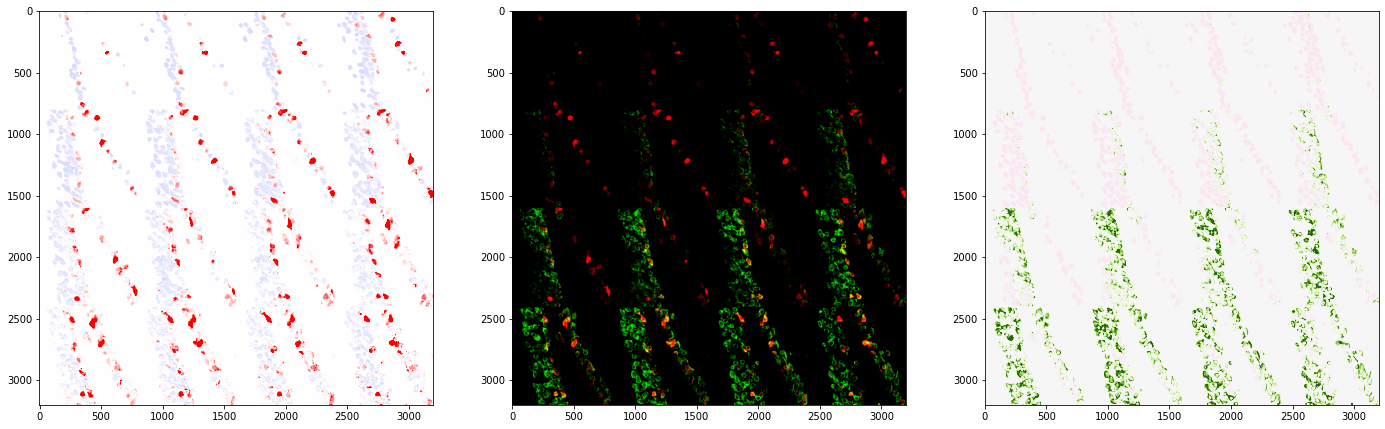

In [105]:
n=3
psize = 8
fig, axs = plt.subplots(1,n,figsize=(psize*n,psize))

merge = np.stack([np.zeros_like(green_zscore_shift) for i in range(3)],axis=-1)
merge[:,:,:,0] = red_zscore_shift
merge[:,:,:,1] = green_zscore_shift
merge = merge/4


m=3
axs[0].imshow(skimage.util.montage(red_zscore_shift),cmap='bwr', vmin=-m,vmax=m)
axs[2].imshow(skimage.util.montage(green_zscore_shift),cmap='PiYG', vmin=-m,vmax=m)

axs[1].imshow(skimage.util.montage(merge,multichannel=True))

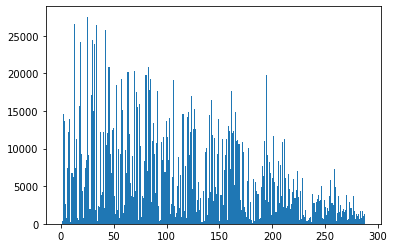

In [90]:
_ = plt.hist(masks.flatten(),bins=np.arange(0,np.nanmax(masks.flatten())))

In [106]:
import pandas as pd

cell_ids =np.arange(0,np.nanmax(masks_og.flatten()))+1
cell_df = pd.DataFrame({'cell_id':cell_ids}).set_index('cell_id')
cell_df['size']=np.nan
cell_df['loc_z']=np.nan
cell_df['loc_z']=cell_df['loc_z'].astype('object')
cell_df['loc_y']=np.nan
cell_df['loc_y']=cell_df['loc_y'].astype('object')
cell_df['loc_x']=np.nan
cell_df['loc_x']=cell_df['loc_x'].astype('object')
cell_df['redness']=np.nan
for c in cell_df.index:
    cell_df.at[c,'size'] = np.nansum((masks_og.flatten()==c)*1.)
    cell_df.at[c,'redness'] = np.sum(  red_zscore[masks_og==c]   )/cell_df.at[c,'size']
    cell_df.at[c,'greeness'] = np.sum(  green_zscore[masks_og==c]   )/cell_df.at[c,'size']


cell_df['large'] = cell_df['size'] > 4000
display(cell_df)

,size,loc_z,loc_y,loc_x,redness,greeness,large
cell_id,,,,,,,
1,342.0,NaN,NaN,NaN,-0.405903,-0.406528,False
2,14637.0,NaN,NaN,NaN,2.347199,-0.249627,True
3,13672.0,NaN,NaN,NaN,0.202426,-0.182683,True
4,2606.0,NaN,NaN,NaN,-0.407735,-0.447933,False
5,775.0,NaN,NaN,NaN,1.044889,-0.457616,False
...,...,...,...,...,...,...,...
285,1721.0,NaN,NaN,NaN,0.187058,1.170089,False
286,979.0,NaN,NaN,NaN,-0.143401,1.422243,False
287,431.0,NaN,NaN,NaN,-0.236989,-0.337587,False


P(R) 0.4358974358974359
P(G) 0.6007326007326007
P(G|R) 0.6722689075630253
P(R|G) 0.4878048780487805
[[80 84]
 [39 70]]
0.035203484652019654


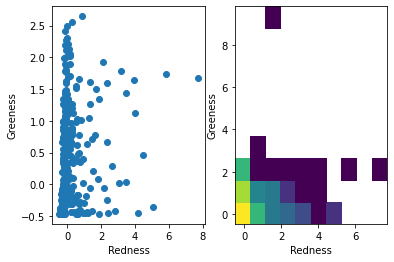

In [108]:
import matplotlib as mpl

cell_df['large'] = cell_df['size'] > 500

fig, ax = plt.subplots(1,2)
ax[0].scatter( cell_df['redness'][cell_df['large']], cell_df['greeness'][cell_df['large']])
ax[0].set_xlabel('Redness')
ax[0].set_ylabel('Greeness')

ax[1].hist2d( cell_df['redness'], cell_df['greeness'], norm=mpl.colors.LogNorm())
ax[1].set_xlabel('Redness')
ax[1].set_ylabel('Greeness')


isR = cell_df['redness']>0
isG = cell_df['greeness']>0

RG = np.sum(np.logical_and(isR[cell_df['large']],isG[cell_df['large']]))
nRG = np.sum(np.logical_and(np.logical_not(isR[cell_df['large']]),isG[cell_df['large']]))
RnG = np.sum(np.logical_and(np.logical_not(isG[cell_df['large']]),isR[cell_df['large']]))
nRnG = np.sum(np.logical_and(np.logical_not(isG[cell_df['large']]),np.logical_not(isR[cell_df['large']])))


print('P(R)',np.mean(isR[cell_df['large']]))
print('P(G)',np.mean(isG[cell_df['large']]))
print('P(G|R)',np.mean(isG[isR][cell_df['large']]))
print('P(R|G)',np.mean(isR[isG][cell_df['large']]))

table = np.array([[RG, nRG],
                  [RnG, nRnG]])
print(table)

oddsratio, p_value =  scipy.stats.fisher_exact(table, alternative='two-sided')
print(p_value)

P(R) 0.4304635761589404
P(G) 0.6423841059602649
P(G|R) 0.7384615384615385
P(R|G) 0.4948453608247423
[[48 49]
 [17 37]]
0.03984726091250135
